In [1]:

#Checking the installed Java version
!java -version
!pip install pyspark 
# Install Java 17
!sudo apt-get update
!sudo apt-get install -y openjdk-17-jdk-headless

!java -version

openjdk version "17.0.14-internal" 2025-01-21
OpenJDK Runtime Environment (build 17.0.14-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 17.0.14-internal+0-adhoc..src, mixed mode, sharing)
Hit:1 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:2 https://download.docker.com/linux/ubuntu noble InRelease                 
Get:3 https://cli.github.com/packages stable InRelease [3917 B]                
Hit:4 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease 
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease
Hit:6 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble InRelease          
Hit:7 https://security.ubuntu.com/ubuntu noble-security InRelease              
Hit:8 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble-updates InRelease  
Hit:9 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble-backports InRelease
Hit:10 http://deb.wakemeops.com/wakemeops stable InRelease                     
Hit:11 h

In [2]:
# Set JAVA_HOME to Java 17
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

In [3]:
#from pyspark.sql import SparkSession
#
#spark = SparkSession.builder\
#        .master("local[*]")\
#        .appName("ML_project") \
#        .getOrCreate()
#print("Spark ready:", spark.version)

In [4]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_curve, auc

# PySpark SQL
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql import types as tp
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, ArrayType, IntegerType, NumericType
)

# PySpark ML - statistics
from pyspark.ml.stat import Correlation

# PySpark ML - feature engineering
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, UnivariateFeatureSelector
)

# PySpark ML - models
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

# PySpark ML - evaluation, tuning, pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.read.parquet("/teamspace/studios/this_studio/loan_data_processed.parquet")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 23:27:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/12 23:27:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
df.count()

44966

In [7]:
df_fs = df

In [8]:
df_fs = df_fs.withColumn('education_encoded',
    when(df_fs['person_education'] == 'High School', 0)
    .when(df_fs['person_education'] == 'Bachelor', 1)
    .when(df_fs['person_education'] == 'Associate', 2)
    .when(df_fs['person_education'] == 'Master', 3)
    .when(df_fs['person_education'] == 'Doctorate', 4))

In [9]:
df_fs.show(10)

+----------+-------------+----------------+-------------+--------------+---------------------+---------+---------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+-----------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|    loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|education_encoded|
+----------+-------------+----------------+-------------+--------------+---------------------+---------+---------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+-----------------+
|      33.0|       female|     High School|      47081.0|          12.0|                 RENT|  10464.0|        MEDICAL|               0.22|                       9.0|       674.0|                           No| 

## Preprocessing ML Pipeline

In [10]:
stages = []

In [11]:
# String Indexers for categorical columns
indexer_gender = StringIndexer(inputCol='person_gender', outputCol='GenderIndex')
indexer_own = StringIndexer(inputCol='person_home_ownership', outputCol='OwndershipIndex')
indexer_loanint = StringIndexer(inputCol='loan_intent', outputCol='LoanIntentIndex')
indexer_prev_loan = StringIndexer(inputCol='previous_loan_dfaults_on_file', outputCol='PrevLoanIndex')
stages += [indexer_gender, indexer_own, indexer_loanint, indexer_prev_loan]

# OneHotEncoder
encoder = OneHotEncoder(
    inputCols=['education_encoded', 'OwndershipIndex', 'LoanIntentIndex'], 
    outputCols=['EducVec', 'OwndershipVec', 'LoanIntentVec']
)
stages.append(encoder)

In [12]:
# Assemble categorical features
assembler_cat = VectorAssembler(
    inputCols=['EducVec', 'OwndershipVec', 'LoanIntentVec', 'GenderIndex', 'PrevLoanIndex'], 
    outputCol='features_cat'
)
stages.append(assembler_cat)

In [13]:
# Assemble numerical features
column_num = [f.name for f in df_fs.schema.fields if isinstance(f.dataType, NumericType) and f.name != "loan_status"]
assembler_num = VectorAssembler(inputCols=column_num, outputCol='features_num')
stages.append(assembler_num)

In [14]:
# Feature selectors
selector_cat = UnivariateFeatureSelector(
    featuresCol="features_cat", outputCol="selectedFeatures_cat",
    labelCol="loan_status", selectionMode="numTopFeatures"
)
selector_cat.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(9)
stages.append(selector_cat)

In [15]:
selector_num = UnivariateFeatureSelector(
    featuresCol="features_num", outputCol="selectedFeatures_num",
    labelCol="loan_status", selectionMode="numTopFeatures"
)
selector_num.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(5)
stages.append(selector_num)

In [16]:
# Scaler
scaler = StandardScaler(inputCol="selectedFeatures_num", outputCol="scaled_num", withMean=True, withStd=True)
stages.append(scaler)

In [17]:
# Final assembler
final_assembler = VectorAssembler(inputCols=['selectedFeatures_cat', 'scaled_num'], outputCol='features')
stages.append(final_assembler)

In [18]:
#Create pipeline
preprocessing_pipeline = Pipeline(stages=stages)

In [19]:
# Split data before pipeline
def stratified_split(df, train_ratio=0.8, target_col='loan_status', seed=42):
    pos = df.filter(F.col(target_col) == 1)
    neg = df.filter(F.col(target_col) == 0)
    train_pos, test_pos = pos.randomSplit([train_ratio, 1-train_ratio], seed=seed)
    train_neg, test_neg = neg.randomSplit([train_ratio, 1-train_ratio], seed=seed)
    return train_pos.union(train_neg), test_pos.union(test_neg)

train_df, test_df = stratified_split(df_fs, train_ratio=0.8)

In [20]:
#Fit pipeline on training data
preprocessing_model = preprocessing_pipeline.fit(train_df)

In [21]:
#Transform train and test data
train_final = preprocessing_model.transform(train_df)
test_final = preprocessing_model.transform(test_df)

In [22]:
train_final.show()

25/12/12 23:27:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+-----------------+-----------+---------------+---------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|      loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|education_encoded|GenderIndex|OwndershipIndex|LoanIntentIndex|PrevLoanIndex|      EducVec|OwndershipVec|LoanIntentVec|        features_cat|        features_num|selectedFeatures_cat|selectedFeatures_num|          scaled_num|            features|
+----------+------

In [23]:
test_final.show()

+----------+-------------+----------------+-------------+--------------+---------------------+---------+-----------------+-------------------+--------------------------+------------+-----------------------------+-----------+---------------------+-----------------+-----------+---------------+---------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|person_age|person_gender|person_education|person_income|person_emp_exp|person_home_ownership|loan_amnt|      loan_intent|loan_percent_income|cb_person_cred_hist_length|credit_score|previous_loan_dfaults_on_file|loan_status|loan_int_rate_percent|education_encoded|GenderIndex|OwndershipIndex|LoanIntentIndex|PrevLoanIndex|      EducVec|OwndershipVec|LoanIntentVec|        features_cat|        features_num|selectedFeatures_cat|selectedFeatures_num|          scaled_num|            features|
+----------+------

## Model Training Pipeline

In [24]:
# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol='loan_status')

In [25]:
#Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="loan_status")
lr_pipeline = Pipeline(stages=stages + [lr])



In [26]:
# Fit on training data
lr_model = lr_pipeline.fit(train_df)

# Make predictions
train_pred = lr_model.transform(train_df)
test_pred = lr_model.transform(test_df)

25/12/12 23:27:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/12 23:27:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [27]:
train_auc = evaluator.evaluate(train_pred)
test_auc = evaluator.evaluate(test_pred)

print(f"Logistic Regression Training AUC: {train_auc:.4f}")
print(f"Logistic Regression Test AUC: {test_auc:.4f}")

Logistic Regression Training AUC: 0.9510
Logistic Regression Test AUC: 0.9544


In [28]:
# Extract the LogisticRegression classifier (last stage)
lr_classifier = lr_model.stages[-1]
# Get training summary
training_summary = lr_classifier.summary

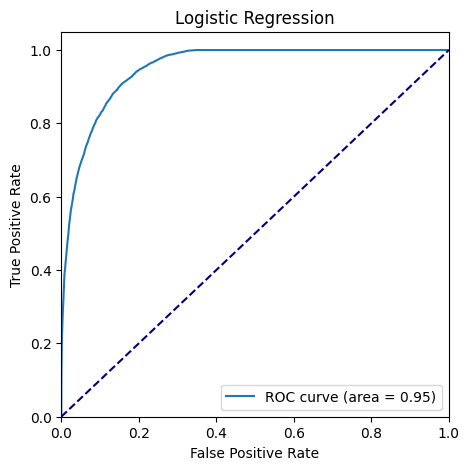

In [29]:
# Your existing plotting code works now
roc_df = training_summary.roc.toPandas()

plt.figure(figsize=(5,5))
plt.plot(roc_df['FPR'], roc_df['TPR'], 
         label='ROC curve (area = %0.2f)' % training_summary.areaUnderROC)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [30]:
def get_feature_names(df, vec_col):
    """Extract real feature names stored in vector metadata."""
    meta = df.schema[vec_col].metadata
    attrs = meta.get("ml_attr", {}).get("attrs", {})
    names = []
    for group in ["binary", "numeric", "nominal"]:
        if group in attrs:
            names.extend([a["name"] for a in attrs[group]])
    return names

Feature Importances (Logistic Regression coefficients):
OwndershipVec_RENT: 0.433
OwndershipVec_MORTGAGE: -0.300
OwndershipVec_OWN: -1.813
LoanIntentVec_EDUCATION: -0.883
LoanIntentVec_MEDICAL: -0.249
LoanIntentVec_VENTURE: -1.232
LoanIntentVec_PERSONAL: -0.698
LoanIntentVec_DEBTCONSOLIDATION: 0.032
PrevLoanIndex: 18.272


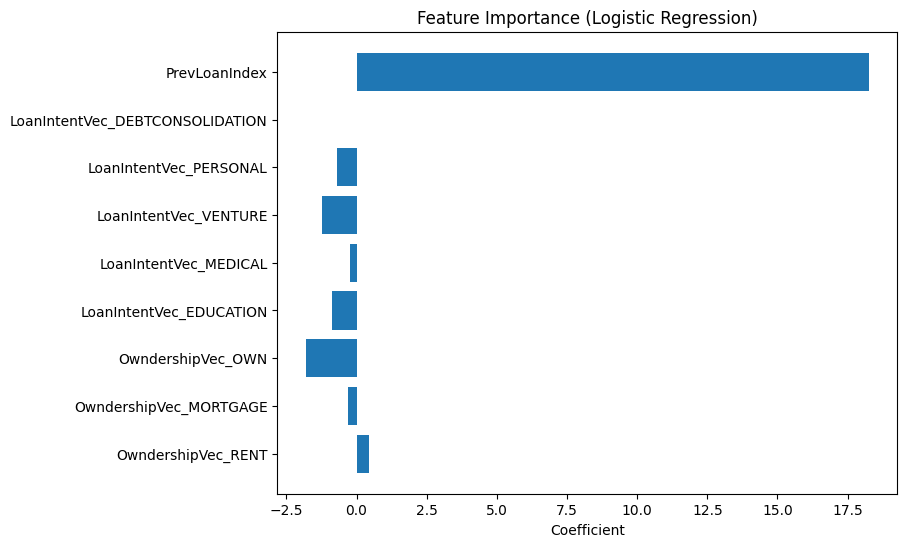

In [31]:
num_feature_names = get_feature_names(train_final, "scaled_num")
cat_feature_names = get_feature_names(train_final, "selectedFeatures_cat")

feature_cols = num_feature_names + cat_feature_names

print('Feature Importances (Logistic Regression coefficients):')
for col, imp in zip(feature_cols, lr_classifier.coefficients):
    print(f'{col}: {imp:.3f}')

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feature_cols, lr_classifier.coefficients[:len(feature_cols)])
ax.set_title('Feature Importance (Logistic Regression)')
ax.set_xlabel('Coefficient')
plt.show()

In [32]:
# Define RF
rf = RandomForestClassifier(
    featuresCol='features', 
    labelCol='loan_status', 
    numTrees=100, 
    maxDepth=5
)

# Create complete pipeline for RF
rf_pipeline = Pipeline(stages=stages + [rf])


In [33]:
# Fit on training data 
rf_model = rf_pipeline.fit(train_df)

# Make predictions
train_pred = rf_model.transform(train_df)
test_pred = rf_model.transform(test_df)


In [34]:
train_auc = evaluator.evaluate(train_pred)
test_auc = evaluator.evaluate(test_pred)

print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Training AUC: 0.9594
Test AUC: 0.9604


In [35]:
# Extract the LogisticRegression classifier (last stage)
rf_classifier = rf_model.stages[-1]


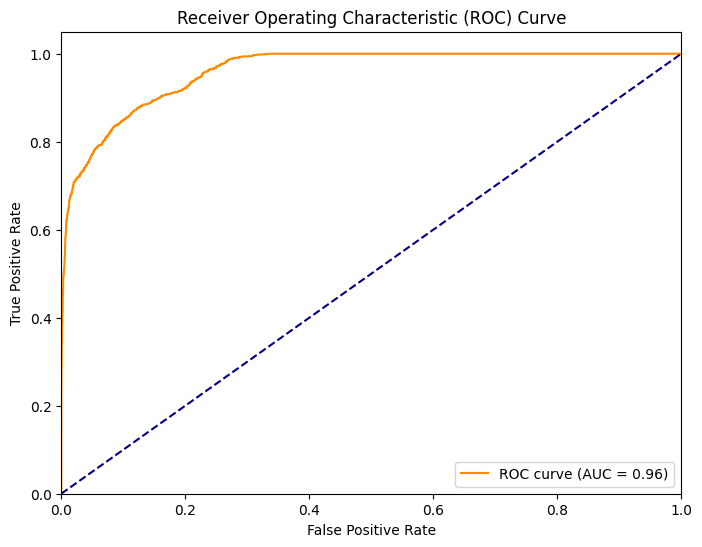

In [36]:
results = test_pred.select(['probability', 'loan_status']).collect()
probs = [float(i[0][1]) for i in results]
labels = [i[1] for i in results]

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Feature Importances:
OwndershipVec_RENT: 0.070
OwndershipVec_MORTGAGE: 0.036
OwndershipVec_OWN: 0.013
LoanIntentVec_EDUCATION: 0.001
LoanIntentVec_MEDICAL: 0.003
LoanIntentVec_VENTURE: 0.002
LoanIntentVec_PERSONAL: 0.000
LoanIntentVec_DEBTCONSOLIDATION: 0.006
PrevLoanIndex: 0.380


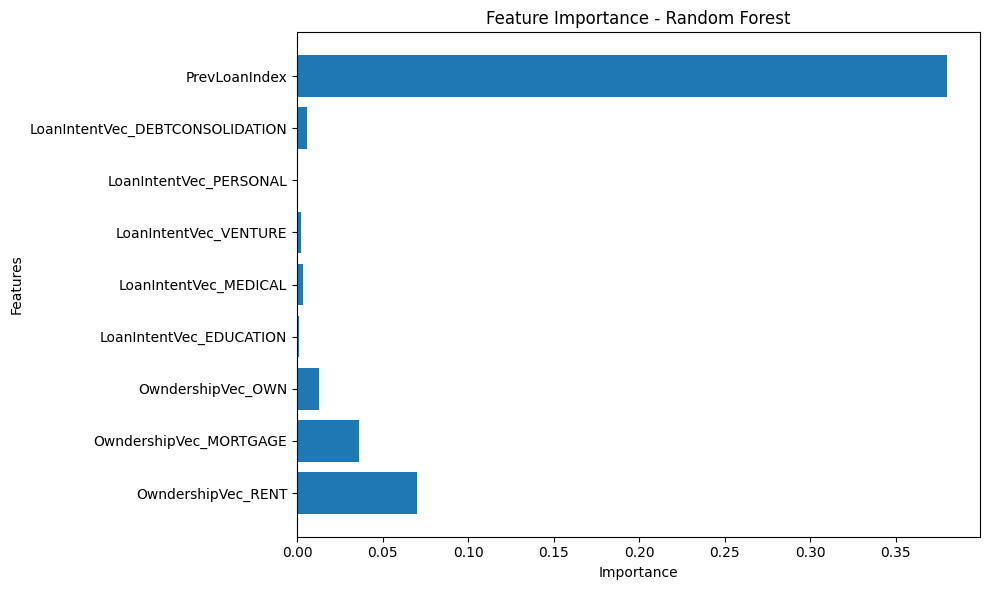

In [37]:
# Get feature importances
importances = rf_classifier.featureImportances.toArray()

print('Feature Importances:')
for col, imp in zip(feature_cols, importances):
    print('{}: {:.3f}'.format(col, imp))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_cols, importances[:len(feature_cols)])
ax.set_title('Feature Importance - Random Forest')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
plt.tight_layout()
plt.show()
